In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import diffusion

import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(100, 512), nn.ReLU(), nn.Linear(512, 1)
)


In [8]:
x = torch.rand((128, 100,))

In [9]:
%%timeit
model(x)

547 µs ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
x = torch.rand((256, 100,))

In [11]:
%%timeit
model(x)

696 µs ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [2]:
def set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled):
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    t = torch.linspace(0, problem.T, problem.Nt)
    x = torch.linspace(problem.L, problem.R, problem.Nx)
    problem.left_values =  problem.left_boundary [nearest_index(t, t_left_sampled) ].to(device)
    problem.right_values = problem.right_boundary[nearest_index(t, t_right_sampled)].to(device)
    problem.init_values =  problem.initial_values[nearest_index(x, x_sampled)      ].to(device)

def grid_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
    t_left_sampled =  torch.linspace(0, problem.T, N_L, requires_grad=True)
    t_right_sampled = torch.linspace(0, problem.T, N_R, requires_grad=True)
    
    k = np.sqrt(problem.Nt * problem.Nx / N_F)
    nt, nx = int(problem.Nt / k), int(problem.Nx / k)
    x_pts, t_pts = [
        pts.reshape(-1, 1) for pts in torch.meshgrid(
        torch.linspace(problem.L, problem.R, nx, requires_grad=True).to(device),
        torch.linspace(0, problem.T, nt, requires_grad=True).to(device),
        indexing='ij'
    )]
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
        
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

def random_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    x_sampled = torch.tensor(np.random.uniform(problem.L, problem.R, N_I), dtype=torch. float32, requires_grad=True)
    t_left_sampled =  torch.tensor(np.random.uniform(0, problem.T, N_L), dtype=torch.float32, requires_grad=True)
    t_right_sampled = torch.tensor(np.random.uniform(0, problem.T, N_R), dtype=torch.float32, requires_grad=True)
    
    x_pts = torch.tensor(np.random.uniform(problem.L, problem.R, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    t_pts = torch.tensor(np.random.uniform(0, problem.T, N_F), requires_grad=True, dtype=torch.float32).reshape(-1, 1)
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
    
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

In [3]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [18]:
problem_number = 2
problem = diffusion.Diffusion.get_problem(problem_number)

L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=2, output_dim=1, activation=nn.Tanh())
name = f'diff{problem_number}_tanh'

num_iters = 10000
plot_every = 250

coef = 0.75
result = train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {"lr": 1e-3},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 10000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {
                'N_I': 128,
                'N_L': 128,
                'N_R': 128,
                'N_F': 2048
                },
            'generation_function': grid_sample
        },
        'coefs': [[coef, coef, coef], [1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    logging_params={
        'loss':  100,
        'norms': 100,
        'error': 100,
        'steps': 100,
        'log_dir': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 5)
    },
    name=name,
    print_every=num_iters + 1
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/diff/{name}_test.gif'
)

KeyboardInterrupt: 

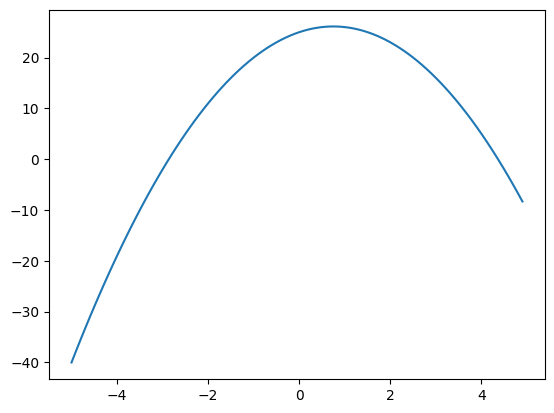

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return -2 * x**2 + 3 * x + 25

x = np.arange(-5, 5, 0.1)
plt.plot(x, f(x))
plt.show()

In [5]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return -2 * x**2 + 3 * x + 25

study = optuna.create_study(
    study_name='test', 
    direction='maximize',
    sampler=optuna.samplers.GPSampler(n_startup_trials=25),
    )
study.optimize(objective, n_trials=100)

print(study.best_params)

C:\Temp\ipykernel_11496\2557212747.py:10: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler=optuna.samplers.GPSampler(n_startup_trials=25),
[I 2024-04-27 18:33:13,636] A new study created in memory with name: test
[I 2024-04-27 18:33:13,639] Trial 0 finished with value: -177.48669026291796 and parameters: {'x': -9.339888261594327}. Best is trial 0 with value: -177.48669026291796.
[I 2024-04-27 18:33:13,641] Trial 1 finished with value: -93.20120039533386 and parameters: {'x': -6.9741892906418945}. Best is trial 1 with value: -93.20120039533386.
[I 2024-04-27 18:33:13,643] Trial 2 finished with value: -111.97493259516128 and parameters: {'x': -7.559630936304009}. Best is trial 1 with value: -93.20120039533386.
[I 2024-04-27 18:33:13,646] Trial 3 finished with value: 11.651859719672215 and parameters: {'x': -1.9400873852281997}. Best is trial 3 with value: 11.651859719672215.
[I 2024-04-27 18:33:13,649] Trial 4 finis

{'x': 0.7500118982998352}


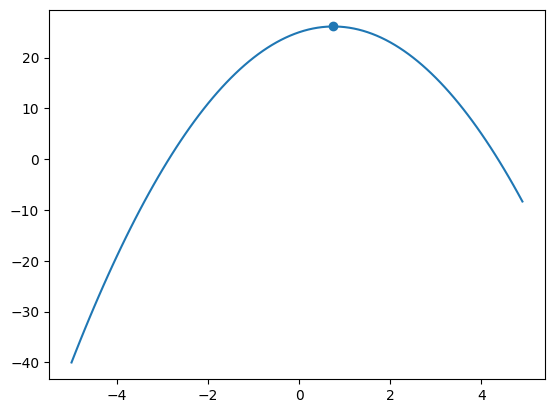

In [6]:
plt.plot(x, f(x))
plt.scatter(study.best_params['x'], f(study.best_params['x']))
plt.show()

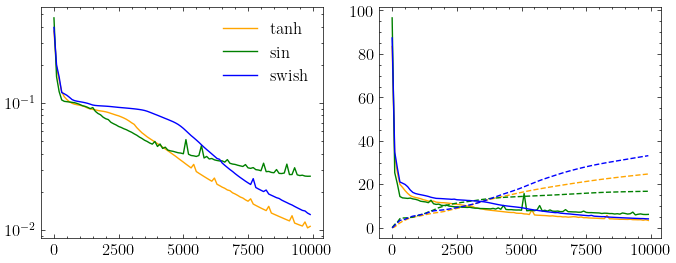

In [14]:
import json
files = ['./logging/diff1.json', './logging/diff1_sin.json', './logging/diff1_swish.json']
colors = ['orange', 'green', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(8, 3), width_ratios=[1, 1])

iters = np.arange(0, num_iters, 100)
for i, activ in enumerate(['tanh', 'sin', 'swish']):
    with open(files[i], 'r') as file:
        log = json.load(file)

    loss_history = []
    error_history = []
    step_history = []
    for j in range(0, num_iters, 100):
        loss_history.append( log[str(j)]['loss'])
        error_history.append(log[str(j)]['error'])
        step_history.append( log[str(j)]['step'])
        
    loss_history =  np.array(loss_history )
    error_history = np.array(error_history)
    step_history =  np.array(step_history )
    
    ax[0].plot(iters, loss_history[:, 2], label=activ, color=colors[i])
    
    ax[1].plot(iters, error_history, label=activ, color=colors[i])
    ax[1].plot(iters, step_history, label=activ, linestyle='dashed', color=colors[i])

ax[0].legend()
ax[0].set_yscale('log')
# ax[1].set_yscale('log')

plt.show()

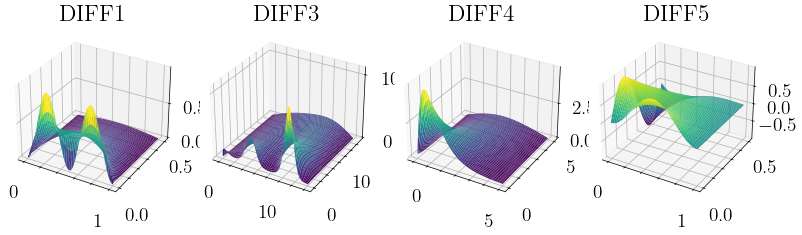

In [2]:
mpl.rcParams["font.size"] = "14"

inds = [1, 3, 4, 5]
problems = [diffusion.Diffusion.get_problem(i) for i in inds]
indexes = [141, 142, 143, 144]

size = (8, 3)
fig = plt.figure(figsize=size)

for i, index, problem in zip(inds, indexes, problems):
    X = problem.domain[:, 0].reshape(problem.Nx, problem.Nt).T
    T = problem.domain[:, 1].reshape(problem.Nx, problem.Nt).T
    ax = fig.add_subplot(index, projection='3d')
    
    ax.plot_surface(X, T, problem.solution, cmap='viridis')
    ax.title.set_text(f'DIFF{i}')
plt.tight_layout()

plt.savefig('../images/diff_grid.png', dpi=250)
plt.show()

## Hyperparameter analysis
---

In [41]:
import torch

def l2(x, y):
    return torch.sqrt(torch.sum(torch.square(x - y)))

x = torch.rand((25, 2)) * 10
pt = torch.tensor([0, 0])
dists = torch.tensor([l2(pt, p) for p in x]).int()

for pt, dist in zip(dists.unique(return_counts=True))

(tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=torch.int32),
 tensor([2, 3, 2, 3, 1, 4, 3, 4, 2, 1]))

tensor([[8.6055, 9.7783],
        [0.6331, 6.8085],
        [6.4126, 3.6918],
        [3.4611, 9.0422],
        [6.4508, 8.5302],
        [3.7579, 9.2198],
        [2.4556, 6.4565],
        [5.3628, 6.5950],
        [5.0687, 3.6617],
        [0.9112, 2.8920],
        [1.4067, 0.5275],
        [6.8751, 0.1156],
        [0.1512, 3.8573],
        [1.2773, 6.0412],
        [9.9584, 0.8261],
        [6.7655, 0.3432],
        [4.4510, 7.4981],
        [8.7372, 3.1464],
        [6.9334, 3.7624],
        [0.7526, 2.6425],
        [9.2230, 3.0914],
        [0.3813, 5.8529],
        [9.3758, 0.1563],
        [9.3164, 5.6033],
        [2.9391, 0.3252]])

In [29]:
x = x.int()
x.unique(return_counts=True)

(tensor([0, 1, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32),
 tensor([3, 2, 3, 4, 3, 3, 2, 1, 4]))

In [1]:
import pandas as pd
from datetime import datetime

def convert(duration):
    time = datetime.strptime(duration[7:], '%H:%M:%S.%f')
    return time.second + time.minute*60 + time.hour*3600

def get_df(name, to_drop, names):
    
    tanh = pd.read_csv(f'./studies/{name}_tanh.csv').drop(to_drop, axis=1)
    tanh['activation'] = 'tanh'
    
    sin = pd.read_csv(f'./studies/{name}_sin.csv').drop(to_drop, axis=1)
    sin['activation'] = 'sin'
    
    swish = pd.read_csv(f'./studies/{name}_swish.csv').drop(to_drop, axis=1)
    swish['activation'] = 'swish'
    
    for df in [tanh, sin, swish]:
        df.columns = names
        df['Duration'] = df['Duration'].apply(convert)
        
    return pd.concat([tanh, sin, swish])

to_drop = ['Unnamed: 0', 'datetime_start', 'datetime_complete', 'state']

In [8]:
diff1 = get_df('diff1', to_drop, ['Trial', 'L2', 'Duration', 'C', 'lr', 'Activation'])
diff2 = get_df('diff2', to_drop, ['Trial', 'L2', 'Duration', 'C', 'lr', 'Activation'])
diff3 = get_df('diff3', to_drop, ['Trial', 'L2', 'Duration', 'C', 'lr', 'Activation'])
diff4 = get_df('diff4', to_drop, ['Trial', 'L2', 'Duration', 'C', 'lr', 'Activation'])
diff5 = get_df('diff5', to_drop, ['Trial', 'L2', 'Duration', 'C', 'lr', 'Activation'])

In [9]:
diff1.sort_values(['L2']).head(5)

,Trial,L2,Duration,C,lr,Activation
10,10,0.748094,120,0.950000,0.034724,swish
8,8,1.138239,120,0.950000,0.044458,swish
13,13,1.269425,87,0.950000,0.005391,tanh
4,4,1.539661,120,0.894456,0.097956,swish
8,8,1.549225,87,0.950000,0.002358,tanh


In [10]:
diff1.groupby(['Activation']).mean()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,7.0,9.748295,89.266667,0.652677,0.016006
swish,7.0,8.413424,120.533333,0.596900,0.031897
tanh,7.0,11.799795,86.400000,0.593040,0.022324


In [11]:
diff1.groupby(['Activation']).std()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,4.472136,10.467385,0.457738,0.336686,0.026194
swish,4.472136,10.020179,0.915475,0.328904,0.033809
tanh,4.472136,12.674517,0.507093,0.364518,0.031434


In [12]:
diff2.sort_values(['L2']).head(5)

,Trial,L2,Duration,C,lr,Activation
0,0,0.869554,87,0.155719,0.001656,sin
12,12,0.934259,87,0.050000,0.001000,sin
9,9,1.260615,121,0.050000,0.003778,swish
1,1,1.263298,87,0.460102,0.001791,sin
10,10,1.385264,121,0.083873,0.001000,swish


In [13]:
diff2.groupby(['Activation']).mean()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,7.0,10.304585,87.000000,0.425273,0.020083
swish,7.0,10.462639,120.533333,0.354703,0.028536
tanh,7.0,20.259028,84.133333,0.446784,0.020564


In [14]:
diff2.groupby(['Activation']).std()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,4.472136,16.884483,0.000000,0.333725,0.029355
swish,4.472136,11.361725,0.516398,0.267533,0.033301
tanh,4.472136,28.071908,0.351866,0.355573,0.035410


In [15]:
diff3.sort_values(['L2']).head(5)

,Trial,L2,Duration,C,lr,Activation
7,7,4.069220,87,0.298203,0.001000,sin
9,9,4.107285,87,0.050000,0.001000,sin
10,10,4.125466,87,0.161147,0.001000,sin
13,13,4.156881,87,0.050000,0.003126,sin
14,14,4.173684,88,0.050000,0.014424,sin


In [16]:
diff3.groupby(['Activation']).mean()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,7.0,32.340501,87.200000,0.296195,0.011782
swish,7.0,31.595523,120.666667,0.388238,0.008901
tanh,7.0,67.523419,84.000000,0.577207,0.010146


In [17]:
diff3.groupby(['Activation']).std()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,4.472136,91.768500,0.414039,0.291238,0.024989
swish,4.472136,30.581202,1.046536,0.276275,0.009614
tanh,4.472136,81.554628,0.000000,0.263786,0.015986


In [18]:
diff4.sort_values(['L2']).head(5)

,Trial,L2,Duration,C,lr,Activation
2,2,4.539755,122,0.846167,0.027745,swish
13,13,4.645021,87,0.455636,0.001000,tanh
11,11,4.723746,87,0.317579,0.004184,tanh
5,5,4.801519,87,0.512797,0.008309,tanh
9,9,4.890838,87,0.463510,0.014659,tanh


In [19]:
diff4.groupby(['Activation']).mean()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,7.0,7.117234,89.066667,0.493891,0.009468
swish,7.0,38.379095,121.866667,0.543587,0.027183
tanh,7.0,9.781993,86.800000,0.470980,0.014819


In [20]:
diff4.groupby(['Activation']).std()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,4.472136,3.316561,0.258199,0.32050,0.009820
swish,4.472136,84.385822,0.990430,0.30040,0.035015
tanh,4.472136,7.289541,0.414039,0.29764,0.016829


In [21]:
diff5.sort_values(['L2']).head(5)

,Trial,L2,Duration,C,lr,Activation
7,7,4.102216,88,0.950000,0.002359,tanh
8,8,4.151882,88,0.950000,0.003399,tanh
12,12,4.202928,88,0.950000,0.004620,tanh
10,10,4.252214,88,0.950000,0.001472,tanh
3,3,4.600905,123,0.743122,0.007222,swish


In [22]:
diff5.groupby(['Activation']).mean()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,7.0,24.420000,91.0,0.555928,0.012734
swish,7.0,10.377643,124.0,0.626952,0.016519
tanh,7.0,53.833249,89.2,0.644111,0.018825


In [23]:
diff5.groupby(['Activation']).std()

,Trial,L2,Duration,C,lr
Activation,,,,,
sin,4.472136,33.020183,0.000000,0.332133,0.019799
swish,4.472136,6.768441,0.377964,0.258385,0.027461
tanh,4.472136,87.655087,1.521278,0.370388,0.032515


In [55]:
from modules.problems import oscillator
from scipy.fft import fft, fftfreq